# Parallel Tempering using pure Python (Multiprocessing)

Parallel tempering is a technique for improving the efficiency of MCMC, especially in the case of multi-modal target distributions. The core idea is to build a sequence of distributions starting with an easy-to-sample reference (e.g. the prior) and ending with the difficult-to-sample target (e.g. the posterior). Given the target $\pi$ and the reference $\pi_0$, this sequence is constructed using a "temperature" parameter $0 < \beta < 1$:
$$\pi_\beta = \pi_0^{1-\beta} \cdot \pi^\beta$$
Here, for $\beta = 0$ (also referred to as "cold" chain) the distribution is equal to the target, for $\beta = 1$ (also referred to as "hot" chain) it is equal to the reference. By running multiple chains with an ascending sequence of temperatures $\beta_0 = 0, \beta_1, \dots, \beta_n = 1$ and allowing theses chains to pass states based on Metropolis-Hastings, the simpler properties of hotter distributions improve the exploration of the state space and can result in faster convergence of the cold chain to the target distribution.

*hopsy* implements parallel tempering. This notebook illustrates it by sampling a mixture of Gaussians that has two distinct modes. Depending on the starting point, vanilla MCMC approaches have trouble capturing the multi-modality. This is because once the chain has found a mode, Metropolis-Hastings proposal are very unlikely to propose high-density points in the other mode. With parallel tempering, the hotter chains are less effected by this and can better sample broadly. By passing these states on to the colder chains, other modes can be explored.

We highly recommend using MPI for maximum performance when using parallel tempering. For examples see parallel_tempering_MPI.py or ParallelTemperingMPI.ipynb.
However, using MPI and mpi4py requires compiling hopsy with your MPI distribution.
This is because we can not assume and/or suppport all possible MPI implementations.

Instead, we provide parallel tempering using Pythons multiprocessing.
The usage is demonstrated in this notebook.

This notebook is the same as parallel_tempering_multiprocessing.py but with iPython and more comments to check whether the example works in Notebooks

In [1]:
import time

import matplotlib.pyplot as plt
import numpy as np

import hopsy
import multiprocessing as mp
import sys

## Defining model type with multimodal density

## Important note:
Functionality within multiprocessing requires that the __main__ module be importable by the children. See https://docs.python.org/3/library/multiprocessing.html#using-a-pool-of-workers.
This means, that the gaussian mixture needs to be imported from a file and not defined here


E.g. the code below is will not work with multiprocessing and jupyter due to python limitations

    GaussianMixture:
        def __init__(self, mu1, mu2):
            epsilon = 0.05
            cov = epsilon * np.eye(2, 2)
            self.model1 = hopsy.Gaussian(mean=mu1, covariance=cov)
            self.model2 = hopsy.Gaussian(mean=mu2, covariance=cov)
    
        def log_density(self, x):
            return np.log(
                np.exp(-self.model1.compute_negative_log_likelihood(x))
                + np.exp(-self.model2.compute_negative_log_likelihood(x))
            )

Instead, we import the Gaussian mixture, like below


In [2]:
from custom_models import GaussianMixture

<!-- ## Setup problem and sampling configuration -->

In [3]:
replicates = 3
n_temps = 4
n_samples = 40_000
thinning = 10

A = np.array([[1, 0], [0, 1], [-1, 0], [0, -1]])
b = np.array([1, 1, 1, 1])

model = GaussianMixture(np.ones(2).reshape(2, 1), -np.ones(2).reshape(2, 1))
problem = hopsy.Problem(A, b, model)

sync_rngs = [hopsy.RandomNumberGenerator(seed=4321 + r) for r in range(replicates)]

temperature_ladder = [1.0 - float(n) / (n_temps - 1) for n in range(n_temps)]

mcs = [
    hopsy.MarkovChain(
        proposal=hopsy.GaussianHitAndRunProposal,
        problem=problem,
        starting_point=0.9 * np.ones(2),
    )
    for r in range(replicates)
]

try:
    epsilon = 100 
    for mc in mcs:
        mc.proposal.stepsize = epsilon
except:
    pass

# Creates one parallel tempering ensemble for each replicate.
# Each ensemble will have len(temperature_ladder) chains.
chains = hopsy.create_py_parallel_tempering_ensembles(
    markov_chains=mcs,
    temperature_ladder=temperature_ladder,
    sync_rngs=sync_rngs,
    draws_per_exchange_attempt=20,
)

rngs = [hopsy.RandomNumberGenerator(i + 1234) for i, _ in enumerate(chains)]

## run and benchmark sampling

In [4]:
start = time.perf_counter()
acc_rate, samples = hopsy.sample(
    markov_chains=chains,
    rngs=rngs,
    n_samples=n_samples,
    thinning=thinning,
    n_procs=len(chains),
)
end = time.perf_counter()
print(
    f"sampling {n_samples} samples with thinning {thinning} and {len(chains)} chains took {end - start} seconds"
)

sampling 40000 samples with thinning 10 and 12 chains took 100.14002706602332 seconds


In [5]:
## Check convergence and plot posterior marginal for first dimension

convergence check for hot samples (rhat<1.01 & ess > 400 means converged)
min ess 117989.07529181667 rhat:  1.0000070989126177
convergence check for cold samples (rhat<1.01 & ess > 400 means converged)
min ess: 25741.320276520106 , rhat:  1.0002144991000597


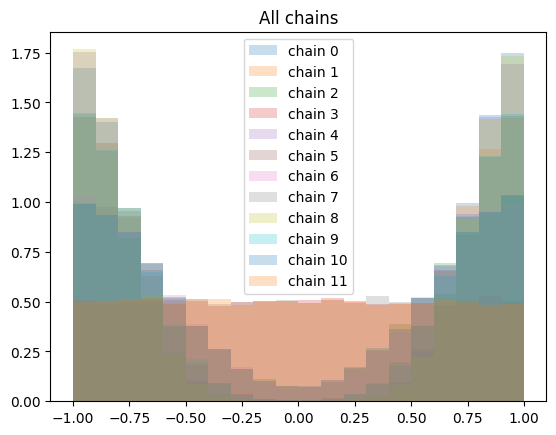

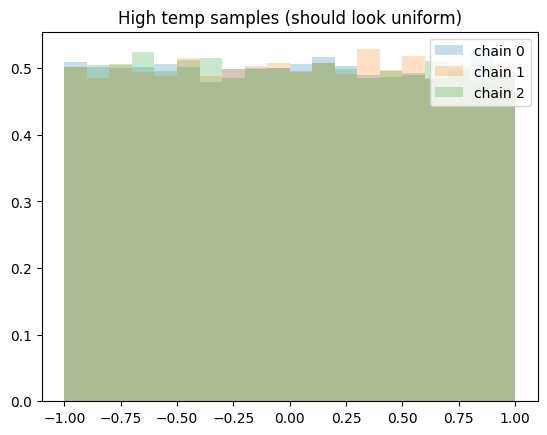

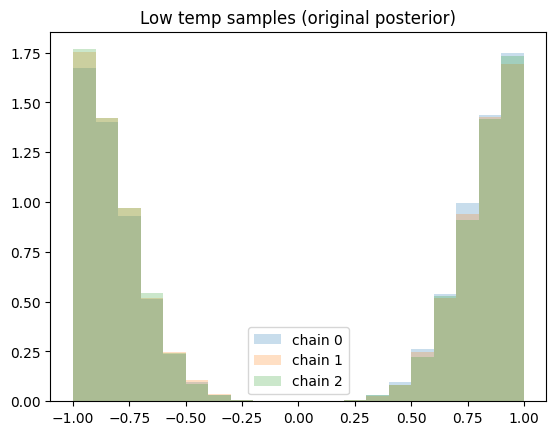

In [6]:
# plots all chains, also the tempered ones
plt.figure()
plt.title("All chains")
for i in range(samples.shape[0]):
    plt.hist(
        samples[i, :, 0], density=True, alpha=0.245, bins=20, label=f"chain {i}"
    )
plt.legend()
# DO not check convergence on all chain samples. It does not make sense, since they sampled different distributions.
# Instead, fetch all samples for a certain temp for convergence checking & plotting

# Fetches and plots the chains with the highest temperature (beta=0):
high_temp_samples = hopsy.get_samples_with_temperature(
    0, temperature_ladder, samples
)
print("convergence check for hot samples (rhat<1.01 & ess > 400 means converged)")
print(
    "min ess",
    np.min(hopsy.ess(high_temp_samples)),
    "rhat: ",
    np.max(hopsy.rhat(high_temp_samples)),
)

plt.figure()
plt.title("High temp samples (should look uniform)")
for i in range(high_temp_samples.shape[0]):
    plt.hist(
        high_temp_samples[i, :, 0],
        density=True,
        alpha=0.245,
        bins=20,
        label=f"chain {i}",
    )
plt.legend()

# Fetchs and plots the chains with the colds temperature (beta=1):
cold_temp_samples = hopsy.get_samples_with_temperature(
    1, temperature_ladder, samples
)
print("convergence check for cold samples (rhat<1.01 & ess > 400 means converged)")
print(
    "min ess:",
    np.min(hopsy.ess(cold_temp_samples)),
    ", rhat: ",
    np.max(hopsy.rhat(cold_temp_samples)),
)
plt.figure()
plt.title("Low temp samples (original posterior)")
for i in range(cold_temp_samples.shape[0]):
    plt.hist(
        cold_temp_samples[i, :, 0],
        density=True,
        alpha=0.245,
        bins=20,
        label=f"chain {i}",
    )
plt.legend()
plt.show()